## Importing Important Libraries

In [101]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [102]:
df = pd.read_csv("storesalesdata.csv")
df.head()

,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
0,S0001,1,3,2012,23401.060,5567.900,3930.280,5223.610,4542.280,238.580,2608.780,1651.770,4304.790
1,S0001,2,3,2012,32442.930,8009.520,4712.310,6174.720,9503.450,245.290,2692.720,2688.890,4467.510
2,S0001,3,3,2012,40433.610,9759.200,5969.030,8010.670,12793.920,282.120,3493.850,2929.850,5721.600
3,S0001,4,3,2012,57043.390,13966.260,9008.240,13142.550,16635.770,316.720,5618.550,4270.380,8313.110
4,S0001,5,3,2012,32894.860,7870.660,5448.350,5459.290,8358.960,198.000,3339.590,2061.210,5280.160


In [103]:
date_cols = ['Day','Month','Year']
for i in date_cols:
    df[i] = df[i].astype('string')

In [104]:
date = df['Month'] + '-' + df['Year']
df['Date'] = date

In [105]:
df['Date'] = pd.to_datetime(df['Date'])

## Forecasting for Existing Stores

In [106]:
new_df = df[['Date','Produce']]

In [107]:
new_df = new_df.groupby(['Date'])['Produce'].sum()

In [108]:
hold_out = new_df[:6]

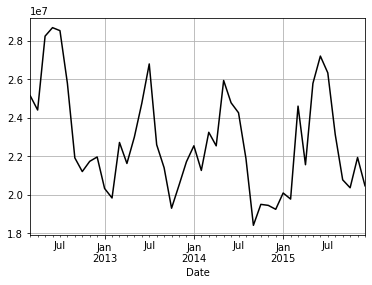

In [109]:
new_df.plot(kind='line', grid=True, color='k');

### Augmented Dickey Fuller Test 

The augmented dickey fuller test is used to check for stationarity in the data. The data is tested and discovered to be stationary.

In [110]:
ADF = adfuller(new_df)
display(ADF)
print ("P-Value is:",ADF[1])

(-2.857670901396688,
 0.050496364857104716,
 9,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 1109.0415098879735)

P-Value is: 0.050496364857104716


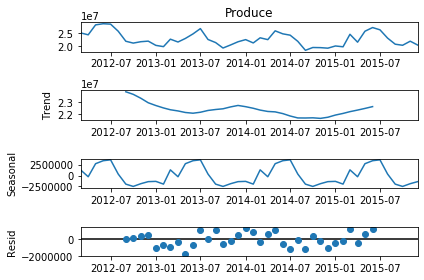

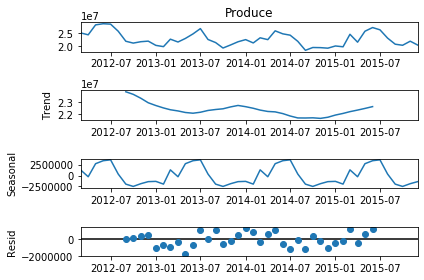

In [111]:
decomp = seasonal_decompose(new_df,period=12)
decomp.plot()

### ACF and PACF Plots

The Autocorrelation and Partial autocorrelation plots are used to check for the correct order of the ARIMA model

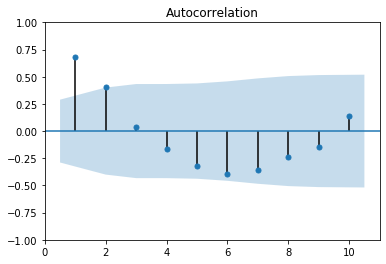

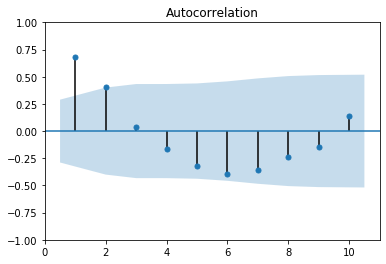

In [112]:
plot_acf(new_df, lags=10, zero=False)

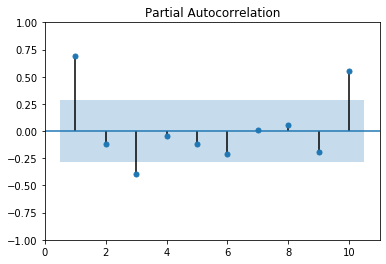

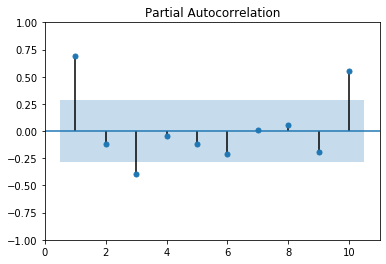

In [113]:
plot_pacf(new_df,lags=10,zero=False)

## Modelling

In [114]:
model = SARIMAX(new_df, order=(1,0,1))
result = model.fit()
print (result.summary())

                               SARIMAX Results                                
Dep. Variable:                Produce   No. Observations:                   46
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -737.491
Date:                Fri, 24 Jun 2022   AIC                           1480.983
Time:                        21:38:35   BIC                           1486.469
Sample:                    03-01-2012   HQIC                          1483.038
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9962      0.012     83.239      0.000       0.973       1.020
ma.L1         -0.0415      0.153     -0.272      0.786      -0.341       0.258
sigma2      4.309e+12   3.11e-15   1.38e+27      0.0

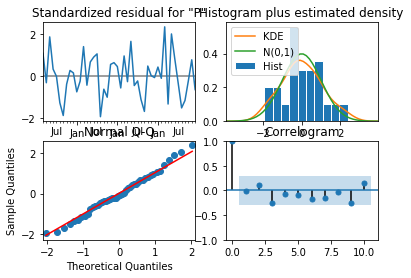

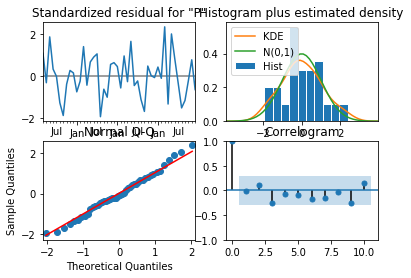

In [115]:
result.plot_diagnostics()

In [116]:
pd.options.display.float_format = '{:.3f}'.format

In [117]:
holdout_forecast = result.get_prediction(start=-6)
holdout_result = round(holdout_forecast.predicted_mean,9)
holdout_result

2015-07-01   27039142.693
2015-08-01   26267848.948
2015-09-01   23173332.250
2015-10-01   20795381.830
2015-11-01   20300972.768
2015-12-01   21785907.663
Freq: MS, Name: predicted_mean, dtype: float64

In [118]:
forecast = result.get_forecast(steps=12)
existing_forecast = round(forecast.predicted_mean,3)

In [119]:
existing_forecast

2016-01-01   20440363.277
2016-02-01   20362969.313
2016-03-01   20285868.387
2016-04-01   20209059.392
2016-05-01   20132541.220
2016-06-01   20056312.771
2016-07-01   19980372.949
2016-08-01   19904720.660
2016-09-01   19829354.815
2016-10-01   19754274.330
2016-11-01   19679478.125
2016-12-01   19604965.123
Freq: MS, Name: predicted_mean, dtype: float64

Time Series forecasting is applied to forecast the average produce sales across existing stores for the 12 months of 2016. To do this, the ARIMA model is applied with an order of (1,0,1).

## Forecasting for New Stores

Since we do not have data for the produce sales of the new stores, we will be forecasting for the clusters they fall under tand then multiplying the results by hte number of new stores in that cluster.

In [120]:
cluster_data = pd.read_csv("Cluster.csv")
cluster_data = cluster_data[['Store','Cluster']]

In [121]:
#Based on the results from the clustering analysis
new_stores = [3,2,2,2,2,1,2,1,2,2]
w = np.arange(86,96)
list_index = []
for i in w:
    j = 'Store '+str(i)
    list_index.append(j)
cluster_new = pd.DataFrame(list_index, columns=['Store'])
cluster_new['Cluster'] = new_stores

In [122]:
cluster_new['Cluster'].value_counts()

2    7
1    2
3    1
Name: Cluster, dtype: int64

In [123]:
df1 = pd.merge(df,cluster_data,on='Store')

In [124]:
df1.head()

,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise,Date,Cluster
0,S0001,1,3,2012,23401.060,5567.900,3930.280,5223.610,4542.280,238.580,2608.780,1651.770,4304.790,2012-03-01,3
1,S0001,2,3,2012,32442.930,8009.520,4712.310,6174.720,9503.450,245.290,2692.720,2688.890,4467.510,2012-03-01,3
2,S0001,3,3,2012,40433.610,9759.200,5969.030,8010.670,12793.920,282.120,3493.850,2929.850,5721.600,2012-03-01,3
3,S0001,4,3,2012,57043.390,13966.260,9008.240,13142.550,16635.770,316.720,5618.550,4270.380,8313.110,2012-03-01,3
4,S0001,5,3,2012,32894.860,7870.660,5448.350,5459.290,8358.960,198.000,3339.590,2061.210,5280.160,2012-03-01,3


In [125]:
cluster1 = df1[df1['Cluster']==1]
cluster2 = df1[df1['Cluster']==2]
cluster3 = df1[df1['Cluster']==3]

In [126]:
cluster1 = cluster1.groupby(['Date'])['Produce'].sum()

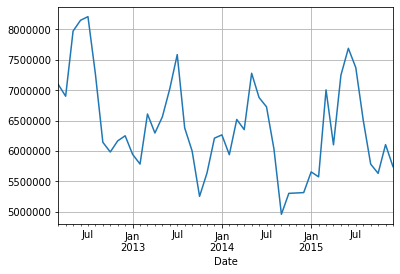

In [127]:
cluster1.plot(grid=True)

In [128]:
ADF = adfuller(cluster1)
display(ADF)
print ("P-Value is:",ADF[1])

(-2.377283775814637,
 0.1482508007140046,
 9,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 1025.8983085967366)

P-Value is: 0.1482508007140046


In [129]:
model = SARIMAX(cluster1, order=(1,0,1))
result = model.fit()
print (result.summary())

                               SARIMAX Results                                
Dep. Variable:                Produce   No. Observations:                   46
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -680.785
Date:                Fri, 24 Jun 2022   AIC                           1367.569
Time:                        21:38:45   BIC                           1373.055
Sample:                    03-01-2012   HQIC                          1369.624
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9958      0.013     78.353      0.000       0.971       1.021
ma.L1         -0.0243      0.149     -0.163      0.871      -0.317       0.268
sigma2      3.689e+11   2.11e-14   1.75e+25      0.0

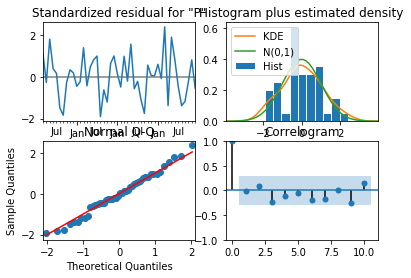

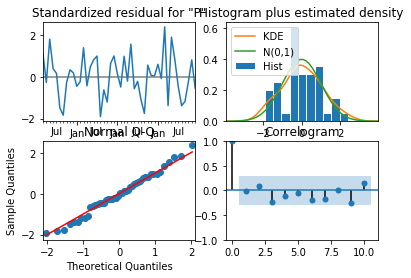

In [130]:
result.plot_diagnostics()

In [131]:
forecast_cluster1 = result.get_forecast(steps=12)
forecast_cluster1 = round(forecast_cluster1.predicted_mean,3)
forecast_cluster1
new_stores_1 = forecast_cluster1*(2/85)

In [132]:
cluster2 = cluster2.groupby(['Date'])['Produce'].sum()

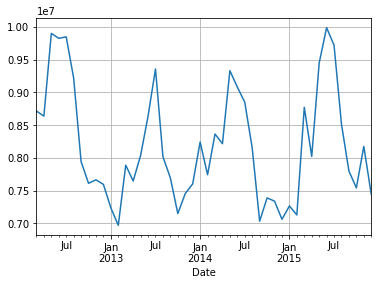

In [133]:
cluster2.plot(grid=True)

In [134]:
ADF = adfuller(cluster2)
display(ADF)
print ("P-Value is:",ADF[1])

(-2.17350939653208,
 0.2160000941672618,
 9,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 1032.3512998582582)

P-Value is: 0.2160000941672618


In [135]:
model = SARIMAX(cluster2, order=(1,0,1))
result = model.fit()
print (result.summary())

                               SARIMAX Results                                
Dep. Variable:                Produce   No. Observations:                   46
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -685.961
Date:                Fri, 24 Jun 2022   AIC                           1377.921
Time:                        21:38:50   BIC                           1383.407
Sample:                    03-01-2012   HQIC                          1379.976
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9967      0.011     88.850      0.000       0.975       1.019
ma.L1         -0.0350      0.171     -0.205      0.838      -0.370       0.300
sigma2      4.599e+11    2.8e-14   1.64e+25      0.0

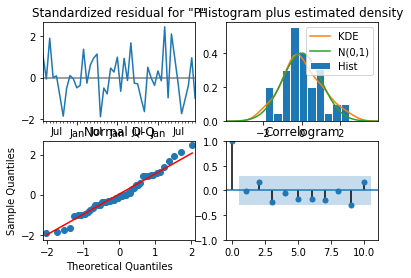

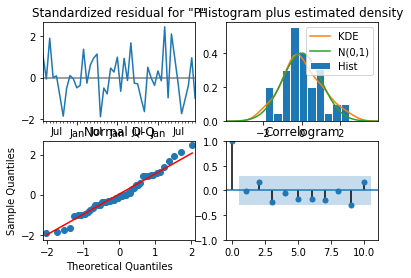

In [136]:
result.plot_diagnostics()

In [137]:
forecast_cluster2 = result.get_forecast(steps=12)
forecast_cluster2 = round(forecast_cluster2.predicted_mean,3)
forecast_cluster2
new_stores_2 = forecast_cluster2*(7/85)

In [138]:
cluster3 = cluster3.groupby(['Date'])['Produce'].sum()

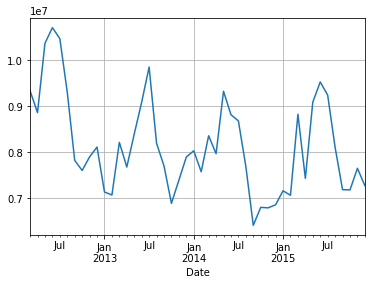

In [139]:
cluster3.plot(grid=True)

In [140]:
ADF = adfuller(cluster3)
display(ADF)
print ("P-Value is:",ADF[1])

(-3.0277820271955718,
 0.032380108710188246,
 9,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 1044.8864063843425)

P-Value is: 0.032380108710188246


In [141]:
model = SARIMAX(cluster3, order=(1,0,1))
result = model.fit()
print (result.summary())

                               SARIMAX Results                                
Dep. Variable:                Produce   No. Observations:                   46
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -694.565
Date:                Fri, 24 Jun 2022   AIC                           1395.130
Time:                        21:39:01   BIC                           1400.616
Sample:                    03-01-2012   HQIC                          1397.186
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9959      0.012     81.698      0.000       0.972       1.020
ma.L1         -0.0720      0.145     -0.497      0.619      -0.356       0.212
sigma2      6.616e+11   2.32e-14   2.85e+25      0.0

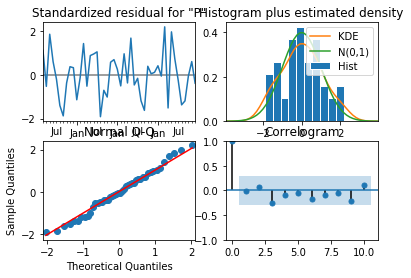

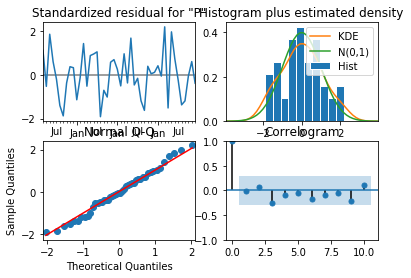

In [142]:
result.plot_diagnostics()

In [143]:
new_stores_3 = result.get_forecast(steps=12)
new_stores_3 = round(new_stores_3.predicted_mean,3)
new_stores_3

2016-01-01   7269010.759
2016-02-01   7239008.205
2016-03-01   7209129.485
2016-04-01   7179374.088
2016-05-01   7149741.505
2016-06-01   7120231.230
2016-07-01   7090842.757
2016-08-01   7061575.584
2016-09-01   7032429.210
2016-10-01   7003403.136
2016-11-01   6974496.867
2016-12-01   6945709.907
Freq: MS, Name: predicted_mean, dtype: float64

In [144]:
new_stores = (new_stores_1 + new_stores_2 + new_stores_3)/3

In [145]:
new_stores

2016-01-01   2672239.262
2016-02-01   2661383.555
2016-03-01   2650572.094
2016-04-01   2639804.698
2016-05-01   2629081.186
2016-06-01   2618401.381
2016-07-01   2607765.103
2016-08-01   2597172.174
2016-09-01   2586622.417
2016-10-01   2576115.655
2016-11-01   2565651.714
2016-12-01   2555230.417
Freq: MS, Name: predicted_mean, dtype: float64